In [1]:
import numpy as np
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.exceptions import NotFittedError
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
class OneHotEncoderWrapper:
    """ One hot encoder class to transfer stagger features
        to binary representation"""
    def __init__(self):
        self.fitted = False
        self.encoder = OneHotEncoder(sparse=False)

    def transform(self, data):
        if not self.fitted:
            self.encoder.fit(data)
            self.fitted = True

        return self.encoder.transform(data)

def generate_stagger_data(encoder, concept_number, count, min_positive_count):
    """ This function generates data for a given stagger concept
    
    Parameters:
    encoder: instance of OneHotEncoderWrapper class
    concept_number: which of the three stagger concepts should be generated
    count: number of objects to be generated
    min_positive_count: minimum number of positive instances returned
    """
    
    size = np.random.choice(["small", "medium", "large"], count)
    color = np.random.choice(["red", "green", "blue"], count)
    shape = np.random.choice(["circle", "rectangle", "triangle"], count)

    positive_indices = np.random.choice(np.arange(count), min_positive_count, replace=False)
    
    #first concept: small circle with red color
    if concept_number == 1:
        size[positive_indices] = "small"
        color[positive_indices] = "red"

        classes = (size == "small") & (color == "red")

    #second concept: green colored object or circle
    elif concept_number == 2:
        green_indices = np.random.choice(positive_indices, int(min_positive_count/2), replace=False)

        color[green_indices] = "green"
        shape[np.setdiff1d(positive_indices, green_indices)] = "circle"

        classes = (color == "green") | (shape == "circle")

    #third concept: medium or large sized object
    elif concept_number == 3:
        medium_indices = np.random.choice(positive_indices, int(min_positive_count/2), replace=False)

        size[medium_indices] = "medium"
        size[np.setdiff1d(positive_indices, medium_indices)] = "large"

        classes = (size == "medium") | (size == "large")

    data = np.array([size, color, shape]).T
    encoded_data = encoder.transform(data)

    return encoded_data, classes

## Reproducing results from the DWM paper on Stagger data

In [3]:
class DynamicWeightedMajority:
    """ Implementation of the DWM algorithm with naive Bayes as base classifier
    
    The algorithm is a dynamic ensamble, that adds new classifiers at each
    timestamp when the overall prediction is wrong. It also decreases the 
    weights of each individual classifier when they make a mistake, and 
    the individual classfiers are dropped once their weights get below 
    a threshold. This way, the ensamble can handle conpect drifts almost 
    with perfect forgetting.
    
    A simple naive Bayes model is also trained at each timestamp for 
    performance comparison.
    """
    def __init__(self, encoder):
        self.encoder = encoder
        self.experts = np.array([])
        self.weights = np.array([])
        self.simple_naive_bayes = BernoulliNB()

    def add_expert(self):
        new_expert = BernoulliNB()
        self.experts = np.append(self.experts, new_expert)
        self.weights = np.append(self.weights, 1.)

    def remove_experts(self, mask):
        self.experts = self.experts[mask]
        self.weights = self.weights[mask]

    def predict_with_expert(self, expert, item):
        try:
            return expert.predict([item])
        except NotFittedError as e:
            # return random prediction when expert is not fitted yet
            return np.random.choice([0, 1])

    def test_experts_on_stagger(self, index, scores, simple_nb_scores):
        # only test with data from the positive class
        if index<40:
            data, _classes = generate_stagger_data(self.encoder, 1, 100, 100)
        elif index<80:
            data, _classes = generate_stagger_data(self.encoder, 2, 100, 100)
        else:
            data, _classes = generate_stagger_data(self.encoder, 3, 100, 100)

        predictions = np.zeros((100,2))
        for exp_idx, expert in enumerate(self.experts):
            pred = expert.predict(data)
            predictions[pred == 1, 1] += self.weights[exp_idx]
            predictions[pred == 0, 0] += self.weights[exp_idx]
        predictions = np.argmax(predictions, axis=1)
        scores.append(predictions.sum()/100)

        simple_nb_preds = self.simple_naive_bayes.predict(data)
        simple_nb_scores.append(simple_nb_preds.sum()/100)


    def fit(self, inputs, targets, class_num, decreasing_factor=0.5, threshold=0.01, periods=1):
        """
        Params:
        inputs: the data points
        targets: the target classes, should have same shape as inputs
        class_num: number of classes
        decreasing_factor: by how much the weight of an individual classifier should
                           be decreased after an error
        threshold: drop classifiers once their wight is less than this threshold
        periods: number of items processed before an update of weights
        """
        scores = []
        simple_nb_scores = []
        expert_counts = []

        self.add_expert()

        for item_idx, item in enumerate(inputs):
            sigma = np.zeros(class_num)
            for exp_idx, exp in enumerate(self.experts):
                pred = self.predict_with_expert(exp, item)
                if pred != targets[item_idx] and item_idx % periods == 0:
                    self.weights[exp_idx] *= decreasing_factor
                sigma[pred] += self.weights[exp_idx]

            final_pred = np.argmax(sigma)

            if(item_idx % periods == 0):
                self.weights = self.weights / np.sum(self.weights)
                mask = self.weights > threshold
                self.remove_experts(mask)

                if final_pred != targets[item_idx]:
                    self.add_expert()

            for exp in self.experts:
                exp.partial_fit([item], [targets[item_idx]], classes=np.arange(class_num))
            self.simple_naive_bayes.partial_fit([item], [targets[item_idx]], classes=np.arange(class_num))

            self.test_experts_on_stagger(item_idx, scores, simple_nb_scores)
            expert_counts.append(len(self.experts))

        return scores, simple_nb_scores, expert_counts

In [4]:
scores, simple_nb_scores, expert_counts = [], [], []
encoder = OneHotEncoderWrapper()
for i in range(0,50):
    first_concept_items, first_concept_classes = generate_stagger_data(encoder, 1, 40, 25)

    second_concept_items, second_concept_classes = generate_stagger_data(encoder, 2, 40, 18)

    third_concept_items, third_concept_classes = generate_stagger_data(encoder, 3, 40, 10)

    inputs = np.concatenate((first_concept_items, second_concept_items, third_concept_items))
    targets = np.concatenate((first_concept_classes, second_concept_classes, third_concept_classes))

    dwm = DynamicWeightedMajority(encoder)
    curr_scores, curr_simple_nb_scores, curr_expert_counts = dwm.fit(inputs, targets, 2)
    scores.append(curr_scores)
    simple_nb_scores.append(curr_simple_nb_scores)
    expert_counts.append(curr_expert_counts)

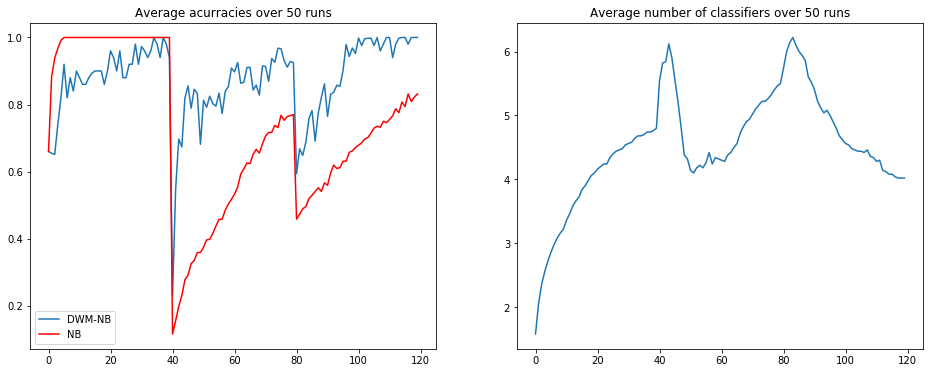

In [5]:
%matplotlib inline
scores = np.concatenate(scores).reshape((50,120))
simple_nb_scores = np.concatenate(simple_nb_scores).reshape((50, 120))
expert_counts = np.concatenate(expert_counts).reshape((50, 120))

plt.figure(1, figsize=(16,6))
plt.subplot(121)
plt.title("Average acurracies over 50 runs")
plt.plot(np.arange(120), np.mean(scores, axis=0), label="DWM-NB")
plt.plot(np.arange(120), np.mean(simple_nb_scores, axis=0), c="red", label="NB")
plt.legend()

plt.subplot(122)
plt.title("Average number of classifiers over 50 runs")
plt.plot(np.arange(120), np.mean(expert_counts, axis=0))

## Individual run

In [6]:
encoder = OneHotEncoderWrapper()

first_concept_items, first_concept_classes = generate_stagger_data(encoder, 1, 40, 25)

second_concept_items, second_concept_classes = generate_stagger_data(encoder, 2, 40, 18)

third_concept_items, third_concept_classes = generate_stagger_data(encoder, 3, 40, 10)

inputs = np.concatenate((first_concept_items, second_concept_items, third_concept_items))
targets = np.concatenate((first_concept_classes, second_concept_classes, third_concept_classes))

dwm = DynamicWeightedMajority(encoder)
curr_scores, curr_simple_nb_scores, curr_expert_counts = dwm.fit(inputs, targets, 2)

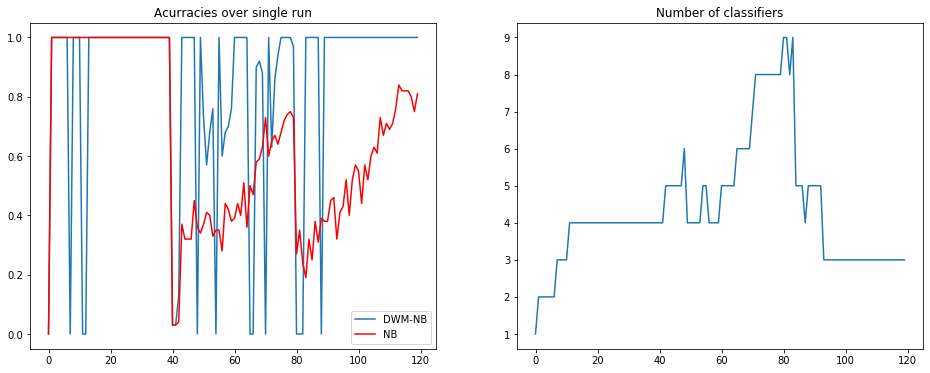

In [7]:
%matplotlib inline

plt.figure(1, figsize=(16,6))
plt.subplot(121)
plt.title("Acurracies over single run")
plt.plot(np.arange(120), curr_scores, label="DWM-NB")
plt.plot(np.arange(120), curr_simple_nb_scores, c="red", label="NB")
plt.legend()

plt.subplot(122)
plt.title("Number of classifiers")
plt.plot(np.arange(120), curr_expert_counts)

## Experimenting with parameters

### Beta

In [8]:
scores, simple_nb_scores, expert_counts = [], [], []
encoder = OneHotEncoderWrapper()
for i in range(0,50):
    first_concept_items, first_concept_classes = generate_stagger_data(encoder, 1, 40, 25)

    second_concept_items, second_concept_classes = generate_stagger_data(encoder, 2, 40, 18)

    third_concept_items, third_concept_classes = generate_stagger_data(encoder, 3, 40, 10)

    inputs = np.concatenate((first_concept_items, second_concept_items, third_concept_items))
    targets = np.concatenate((first_concept_classes, second_concept_classes, third_concept_classes))

    dwm = DynamicWeightedMajority(encoder)
    curr_scores, curr_simple_nb_scores, curr_expert_counts = dwm.fit(inputs, targets, 2, 
                                                                     decreasing_factor=0.1)
    scores.append(curr_scores)
    simple_nb_scores.append(curr_simple_nb_scores)
    expert_counts.append(curr_expert_counts)
    
scores_small_beta = np.concatenate(scores).reshape((50,120))
simple_nb_scores_small_beta = np.concatenate(simple_nb_scores).reshape((50, 120))
expert_counts_small_beta = np.concatenate(expert_counts).reshape((50, 120))

In [9]:
scores, simple_nb_scores, expert_counts = [], [], []
encoder = OneHotEncoderWrapper()
for i in range(0,50):
    first_concept_items, first_concept_classes = generate_stagger_data(encoder, 1, 40, 25)

    second_concept_items, second_concept_classes = generate_stagger_data(encoder, 2, 40, 18)

    third_concept_items, third_concept_classes = generate_stagger_data(encoder, 3, 40, 10)

    inputs = np.concatenate((first_concept_items, second_concept_items, third_concept_items))
    targets = np.concatenate((first_concept_classes, second_concept_classes, third_concept_classes))

    dwm = DynamicWeightedMajority(encoder)
    curr_scores, curr_simple_nb_scores, curr_expert_counts = dwm.fit(inputs, targets, 2, 
                                                                     decreasing_factor=0.9)
    scores.append(curr_scores)
    simple_nb_scores.append(curr_simple_nb_scores)
    expert_counts.append(curr_expert_counts)
    
scores_high_beta = np.concatenate(scores).reshape((50,120))
simple_nb_scores_high_beta = np.concatenate(simple_nb_scores).reshape((50, 120))
expert_counts_high_beta = np.concatenate(expert_counts).reshape((50, 120))

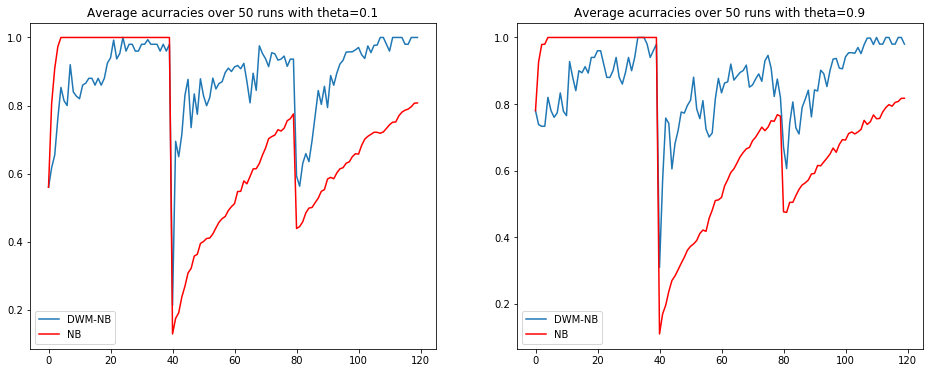

In [10]:
%matplotlib inline

plt.figure(1, figsize=(16,6))
plt.subplot(121)
plt.title("Average acurracies over 50 runs with theta=0.1")
plt.plot(np.arange(120), np.mean(scores_small_beta, axis=0), label="DWM-NB")
plt.plot(np.arange(120), np.mean(simple_nb_scores_small_beta, axis=0), c="red",label="NB")
plt.legend()

plt.subplot(122)
plt.title("Average acurracies over 50 runs with theta=0.9")
plt.plot(np.arange(120), np.mean(scores_high_beta, axis=0), label="DWM-NB")
plt.plot(np.arange(120), np.mean(simple_nb_scores_high_beta, axis=0), c="red",label="NB")
plt.legend()

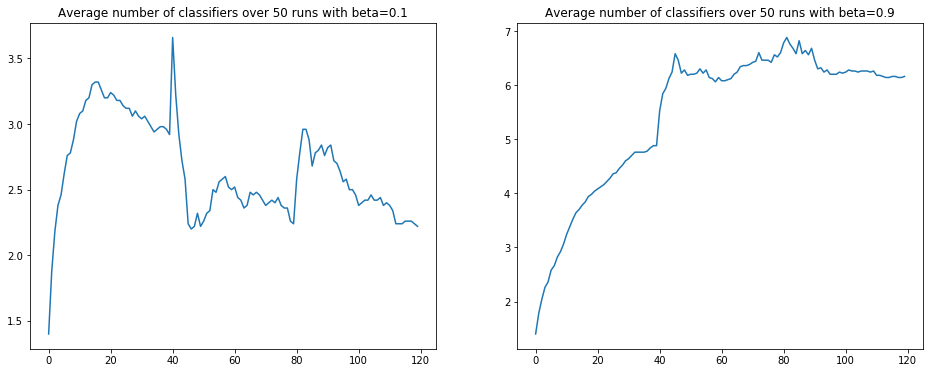

In [11]:
%matplotlib inline

plt.figure(1, figsize=(16,6))
plt.subplot(121)
plt.title("Average number of classifiers over 50 runs with beta=0.1")
plt.plot(np.arange(120), np.mean(expert_counts_small_beta, axis=0))


plt.subplot(122)
plt.title("Average number of classifiers over 50 runs with beta=0.9")
plt.plot(np.arange(120), np.mean(expert_counts_high_beta, axis=0))

### Periods

In [12]:
encoder = OneHotEncoderWrapper()

first_concept_items, first_concept_classes = generate_stagger_data(encoder, 1, 40, 25)

second_concept_items, second_concept_classes = generate_stagger_data(encoder, 2, 40, 18)

third_concept_items, third_concept_classes = generate_stagger_data(encoder, 3, 40, 10)

inputs = np.concatenate((first_concept_items, second_concept_items, third_concept_items))
targets = np.concatenate((first_concept_classes, second_concept_classes, third_concept_classes))

dwm = DynamicWeightedMajority(encoder)
curr_scores, curr_simple_nb_scores, curr_expert_counts = dwm.fit(inputs, targets, 2, periods=4)

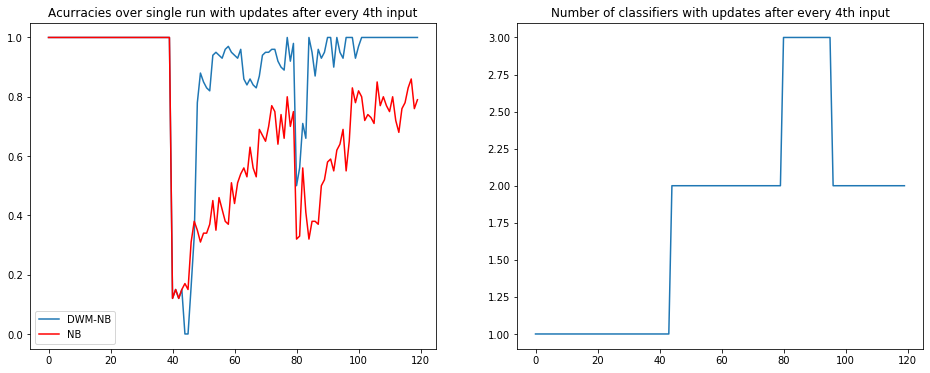

In [13]:
%matplotlib inline

plt.figure(1, figsize=(16,6))
plt.subplot(121)
plt.title("Acurracies over single run with updates after every 4th input")
plt.plot(np.arange(120), curr_scores, label="DWM-NB")
plt.plot(np.arange(120), curr_simple_nb_scores, c="red", label="NB")
plt.legend()

plt.subplot(122)
plt.title("Number of classifiers with updates after every 4th input")
plt.plot(np.arange(120), curr_expert_counts)